# Getting LR Images from HR Source

This notebook created LR images of varying levels of blur and added noise from the HR sources.

In [30]:
import astropy
from astropy.io import fits
from PIL import Image
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.convolution import Gaussian2DKernel, convolve
from astropy import units as u
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np 
import glob
import os
import matplotlib.pyplot as plt
import torch

import sys
sys.path.append('../')  # locally defined
from utils_custom import calc_psnr, calc_ssim, calc_sssim # modify utils to utils_custom to avoid conflict with Python package 'utils'


In [31]:
"""
HR -> LR methods
"""

def normalize_image(image, max_val):
    image = np.clip(image, a_min=0.0, a_max=max_val)

    # Normalize the image
    image = image / max_val

    # Clip the final image in order to prevent rounding errors
    image = np.clip(image, a_min=0.0, a_max=1.0)

    return image

def add_psf(image, x_stddev):    
    psf = Gaussian2DKernel(x_stddev)
    psf_img = convolve(image, psf, boundary='wrap')
    return psf_img


def add_noise(image, gaussian_scale, poisson_scale):
    gaussian_noise = gaussian_scale * np.random.normal(loc=0, scale=2, size=image.shape)
    poisson_noise = poisson_scale * np.random.poisson(image)
    return np.clip((image + gaussian_noise + poisson_noise), 0, 1)


def crop_crop(imarray):
    # fixed height and width of cropped image, determined by min pixel height/width 
    # of images in our data set
    pixel_val = 256
    height = imarray.shape[0]
    width = imarray.shape[1]
    cropped_imarray = imarray[int(height//2-pixel_val/2):int(height//2+pixel_val/2), int(width//2-pixel_val/2):int(width//2+pixel_val/2)]
    if cropped_imarray.shape != (256, 256):
        print(cropped_imarray.shape)
    return cropped_imarray
    
    


### THE ONLY CELL BELOW: MODIFY VALUES TO CATER

In [ ]:
image_dataset_name = 'FITS_TEST' # put this image dataset folder paralleled to 'code_main' folder
image_format = 'fits' # choose 'fits' or 'tif'
change = '4_001' # choose the change from hr to lr here, '10_0015' or '10_001' or '4_001'

In [33]:
hr_dir = '../../'+image_dataset_name # input; original HR images
se_hr_dir = '../../Prep_Images/'+image_dataset_name+'_se_hr_'+change # output; processed HR images(decolorated, normalized, cropped, details selected)
se_lr_dir = '../../Prep_Images/'+image_dataset_name+'_se_lr_'+change  # output; processed LR images(PSF added, noise added, details selected)

In [34]:
result_data_folder_name = 'result_data_'+image_dataset_name+'/' # output; result csv data
result_plot_folder_name = 'result_plot_'+image_dataset_name+'/' # output; result bar plot

In [35]:
os.makedirs(se_hr_dir, exist_ok=True)
os.makedirs(se_lr_dir, exist_ok=True)

# set parameters for HR -> LR methods acrording to 'change'
if change == '4_001':
    x_stddev = 4
    gaussian_scale = 0.01
    poisson_scale = 0.01
elif change == '10_001':
    x_stddev = 10
    gaussian_scale = 0.01
    poisson_scale = 0.01
elif change == '10_0015':
    x_stddev = 10
    gaussian_scale = 0.015
    poisson_scale = 0.015
else:
    raise ValueError("Invalid change value. Choose between '4_001', '10_001', or '10_0015'.")

In [22]:
"""
GET LR IMAGES FROM HR IMAGES IN ALL FORMATS
"""

ind = 0
for filename in glob.glob(os.path.join(hr_dir, '*.'+image_format)):
    ind += 1

    # read in image
    if image_format == 'fits':
        image_file = get_pkg_data_filename(filename)
        imarray = fits.getdata(image_file, ext=0).astype(np.float32)
    else: # tif
        image = Image.open(filename).convert('L') # convert to grayscale; reduce dimensions from 3D to 2D
        imarray = np.array(image).astype(np.float32)

    img=imarray

    # normalize image
    max_val = np.max(imarray)
    if max_val == 0:
        continue
    img = normalize_image(imarray, max_val)
    
        
    # crop image to 256x256
    img = crop_crop(img)
    if img.shape != (256,256):
        continue
    
    # add PSF and noise
    psf_img = add_psf(image=img, x_stddev=x_stddev)
    lr_img = add_noise(image=psf_img, gaussian_scale=gaussian_scale, poisson_scale=poisson_scale)
    
    # save hr image
    filename_hr = os.path.join(se_hr_dir, filename.split("/")[-1])
    if image_format == 'fits':
        hdu = fits.PrimaryHDU(img)
        hdu.writeto(filename_hr, overwrite=True)
    else: # tif
        Image.fromarray(img).save(filename_hr)
    

    # save lr image
    filename_lr = os.path.join(se_lr_dir, 'lr_' + filename.split("/")[-1])
    if image_format == 'fits':
        hdu = fits.PrimaryHDU(lr_img)
        hdu.writeto(filename_lr, overwrite=True)
    else: # tif
        Image.fromarray(lr_img).save(filename_lr)

    print(ind)

1
2
3
4
5
6
7
8
9
10


In [ ]:
"""
GET SELECTIVE HR IMAGES AND LR IMAGES IN ALL FORMATS
"""

ind = 0
for filename in glob.glob(os.path.join(hr_dir, '*.'+image_format)):
    ind += 1

    if image_format == 'fits':
        image_file = get_pkg_data_filename(filename)
        imarray = fits.getdata(image_file, ext=0).astype(np.float32)
    else: # tif
        image = Image.open(filename).convert('L')
        imarray = np.array(image).astype(np.float32)

    img=imarray

    max_val = np.max(imarray)
    if max_val == 0:
        continue
    img = normalize_image(imarray, max_val)
    
    data = img.flatten()
    data = data.reshape(-1,1)
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=23) # use clustering method with k=3
    kmeans.fit(data)
    if len(np.unique(kmeans.labels_)) == 1:
        continue
        
    img = crop_crop(img)
    if img.shape != (256,256):
        continue
    

    psf_img = add_psf(image=img, x_stddev=x_stddev)
    lr_img = add_noise(image=psf_img, gaussian_scale=gaussian_scale, poisson_scale=poisson_scale)

    # define selective hr image
    data = img.flatten()
    data = data.reshape(-1,1)

    kmeans = KMeans(n_clusters=3, n_init=10, random_state=23)
    kmeans.fit(data)
    
    df = pd.DataFrame({'brightness': img.flatten(),
                        'label': kmeans.labels_})
        
    background_label = df.loc[df['brightness'].idxmin()]['label']
    data = data.reshape(img.shape)
    labels = kmeans.labels_.reshape(img.shape[0],img.shape[1])
    background_array = 1 * (labels == background_label)
    detailed_array = 1*(labels != background_label)
    img = detailed_array * img

    # save hr image
    filename_hr = os.path.join(se_hr_dir, 'se_' + filename.split("/")[-1])
    if image_format == 'fits':
        hdu = fits.PrimaryHDU(img)
        hdu.writeto(filename_hr, overwrite=True)
    else: # tif
        Image.fromarray(img).save(filename_hr)

    # define selective lr image
    data = lr_img.flatten()
    data = data.reshape(-1,1)
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=23)
    kmeans.fit(data)
    
    df = pd.DataFrame({'brightness': img.flatten(),
                        'label': kmeans.labels_})
        
    background_label = df.loc[df['brightness'].idxmin()]['label']
    data = data.reshape(lr_img.shape)
    labels = kmeans.labels_.reshape(lr_img.shape[0],lr_img.shape[1])
    background_array = 1 * (labels == background_label)
    detailed_array = 1*(labels != background_label)
    lr_img = detailed_array * lr_img 
    
    # save lr image
    filename_lr = os.path.join(se_lr_dir, 'lr_se_' + filename.split("/")[-1])
    if image_format == 'fits':
        hdu = fits.PrimaryHDU(lr_img)
        hdu.writeto(filename_lr, overwrite=True)
    else: # tif
        Image.fromarray(lr_img).save(filename_lr)

    print(ind)

1
2
3
4
5
6
7
8
9
10


In [37]:
"""
CALCULATE PSNR, SSIM, SSSIM BETWEEN (SELECTIVE) HR AND LR IMAGES IN ALL FORMATS
"""

ssim_vals = []
sssim_vals = []
psnr_vals = []

ind = 0
for filename in glob.glob(os.path.join(se_hr_dir, '*.'+image_format)):
    ind += 1

    if image_format == 'fits':
        img_hr = get_pkg_data_filename(filename)
        imarray_hr = fits.getdata(img_hr, ext=0).astype(np.float32)
    else: # tif
        img_hr = Image.open(filename)
        imarray_hr = np.array(img_hr).astype(np.float32)

    filename_lr = os.path.join(se_lr_dir, 'lr_' + filename.split("/")[-1])
    if image_format == 'fits':
        img_lr = get_pkg_data_filename(filename_lr)
        imarray_lr = fits.getdata(img_lr, ext=0).astype(np.float32)
    else: # tif
        img_lr = Image.open(filename_lr)
        imarray_lr = np.array(img_lr).astype(np.float32)

    img_1 = imarray_hr.reshape(1, imarray_hr.shape[0], imarray_hr.shape[1])
    img_2 = imarray_lr.reshape(1, imarray_lr.shape[0], imarray_lr.shape[1])

    sssim_vals.append(calc_sssim(torch.Tensor(img_1), torch.Tensor(img_2)).item())
    ssim_vals.append(calc_ssim(torch.Tensor(img_1), torch.Tensor(img_2)).item())
    psnr_vals.append(calc_psnr(torch.Tensor(img_1), torch.Tensor(img_2)).item())
    
    print(ind)
    
sssim_vals_df = pd.DataFrame(sssim_vals)
ssim_vals_df = pd.DataFrame(ssim_vals)
psnr_vals_df = pd.DataFrame(psnr_vals)

os.makedirs(result_data_folder_name, exist_ok=True)
sssim_vals_df.to_csv(result_data_folder_name+'sssim_'+change+'.csv')
ssim_vals_df.to_csv(result_data_folder_name+'ssim_'+change+'.csv')
psnr_vals_df.to_csv(result_data_folder_name+'psnr_'+change+'.csv')

1
2
3
4
5
6
7
8
9
10


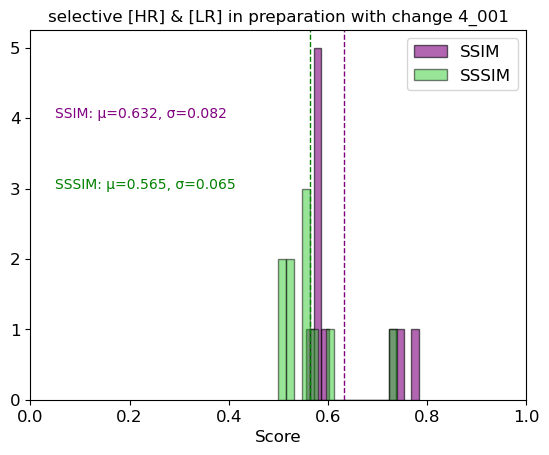

In [39]:
"""
BAR PLOT FOR SSIM AND SSSIM
"""

ssim_vals = pd.read_csv(result_data_folder_name+'ssim_' + change + '.csv', index_col=0)
sssim_vals = pd.read_csv(result_data_folder_name+'sssim_' + change + '.csv', index_col=0)
ssim_vals = ssim_vals.iloc[:, 0].tolist()
sssim_vals = sssim_vals.iloc[:, 0].tolist()

ssim_mean = np.mean(ssim_vals)
ssim_std = np.std(ssim_vals)
sssim_mean = np.mean(sssim_vals)
sssim_std = np.std(sssim_vals)

plt.figure()
plt.hist(ssim_vals, bins=15, alpha=0.6, color='purple', edgecolor='black', label='SSIM')
plt.hist(sssim_vals, bins=15, alpha=0.5, color='limegreen', edgecolor='black', label='SSSIM')

# text axis should be appropriately adjusted to lie in a reasonable place
plt.text(0.05, 4, f'SSIM: μ={ssim_mean:.3f}, σ={ssim_std:.3f}', fontsize=10, color='purple')
plt.text(0.05, 3, f'SSSIM: μ={sssim_mean:.3f}, σ={sssim_std:.3f}', fontsize=10, color='green')

plt.axvline(ssim_mean, color='purple', linestyle='dashed', linewidth=1)
plt.axvline(sssim_mean, color='green', linestyle='dashed', linewidth=1)

plt.legend(fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(xmin=0, xmax=1)
plt.title("selective [HR] & [LR] in preparation with change "+change)

os.makedirs(result_plot_folder_name, exist_ok=True)
plt.savefig(result_plot_folder_name+'ssim_'+change+'.png')


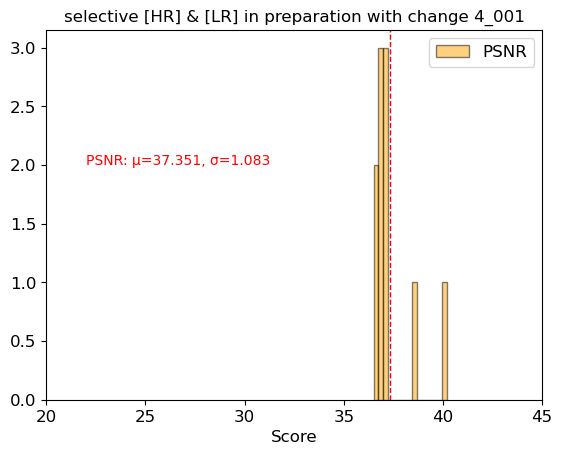

In [41]:
"""
BAR PLOT FOR PSNR
"""

psnr_vals = pd.read_csv(result_data_folder_name+'psnr_' + change + '.csv', index_col=0)
psnr_vals = psnr_vals.iloc[:, 0].tolist()

psnr_mean = np.mean(psnr_vals)
psnr_std = np.std(psnr_vals)

plt.figure()
plt.hist(psnr_vals, bins=15, alpha=0.5, color='orange', edgecolor='black', label='PSNR')

# text axis should be appropriately adjusted to lie in a reasonable place
plt.text(22, 2, f'PSNR: μ={psnr_mean:.3f}, σ={psnr_std:.3f}', fontsize=10, color='red')

plt.axvline(psnr_mean, color='red', linestyle='dashed', linewidth=1)

plt.legend(fontsize=12)
plt.xlabel('Score', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(xmin=20, xmax=45)
plt.title("selective [HR] & [LR] in preparation with change "+change)

os.makedirs(result_plot_folder_name, exist_ok=True)
plt.savefig(result_plot_folder_name+'psnr_'+change+'.png')
